In [ ]:
# Instalacija biblioteka za Neural CDE
!pip install torchcde
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 16.4 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

CharacterTrajectories_TEST.ts: 0.00B [00:00, ?B/s]

CharacterTrajectories_TRAIN.ts: 0.00B [00:00, ?B/s]

--- PODACI SPREMNI ---
Train set oblik: torch.Size([2286, 182, 4])
Test set oblik: torch.Size([572, 182, 4])
Broj klasa: 20


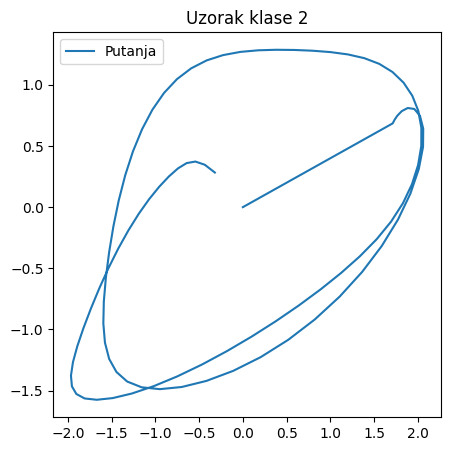

In [ ]:
import torch
import torchcde
import numpy as np
import matplotlib.pyplot as plt
from sktime.datasets import load_UCR_UEA_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def get_data():
    # 1. Učitavanje (X_df je DataFrame gdje je svaka ćelija zapravo Series/niz)
    X_df, y = load_UCR_UEA_dataset(name='CharacterTrajectories', return_X_y=True)

    list_of_tensors = []

    # 2. Iteracija kroz svaki red (uzorak)
    for i in range(len(X_df)):
        # Izvlačimo kanale (0=x, 1=y, 2=force)
        # Koristimo .iloc[i, c] i osiguravamo da je to numpy niz
        c0 = np.array(X_df.iloc[i, 0])
        c1 = np.array(X_df.iloc[i, 1])
        c2 = np.array(X_df.iloc[i, 2])

        # Pronalazimo minimalnu dužinu da izbjegnemo "arrays must have the same shape"
        min_len = min(len(c0), len(c1), len(c2))

        # Siječemo na istu dužinu i spajamo u (Length, 3)
        sample = np.stack([c0[:min_len], c1[:min_len], c2[:min_len]], axis=1)
        list_of_tensors.append(torch.tensor(sample, dtype=torch.float32))

    # 3. Padding - dopunjavamo nule na kraj da svi uzorci u datasetu imaju istu dužinu
    # To nam omogućava da imamo jedan veliki Tensor (Batch, Length, Channels)
    X_padded = torch.nn.utils.rnn.pad_sequence(list_of_tensors, batch_first=True)

    # 4. Dodavanje vremenske dimenzije (t) od 0 do 1
    batch_size, seq_len, channels = X_padded.shape
    times = torch.linspace(0, 1, seq_len).unsqueeze(0).unsqueeze(2).repeat(batch_size, 1, 1)
    X_final = torch.cat([times, X_padded], dim=2)

    # 5. Labeliranje
    le = LabelEncoder()
    y_final = torch.tensor(le.fit_transform(y), dtype=torch.long)

    return X_final, y_final

# Izvršavanje i podjela na train/test
try:
    X, y = get_data()

    # Podjela podataka na trening i test set (80/20)
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

    print("--- PODACI SPREMNI ---")
    print(f"Train set oblik: {train_X.shape}")
    print(f"Test set oblik: {test_X.shape}")
    print(f"Broj klasa: {len(torch.unique(y))}")

    # Vizualizacija da potvrdimo da je sve OK
    plt.figure(figsize=(5,5))
    plt.plot(train_X[0, :, 1], train_X[0, :, 2], label='Putanja')
    plt.title(f"Uzorak klase {train_y[0].item()}")
    plt.legend()
    plt.show()

except Exception as e:
    print(f"Greška prilikom obrade: {e}")

In [ ]:
import torchcde

def prepare_splines(train_data, test_data):
    print("Izračunavam koeficijente splajnova za trening set...")
    train_coeffs = torchcde.natural_cubic_coeffs(train_data)

    print("Izračunavam koeficijente splajnova za test set...")
    test_coeffs = torchcde.natural_cubic_coeffs(test_data)

    return train_coeffs, test_coeffs

# Izvršavanje transformacije
train_coeffs, test_coeffs = prepare_splines(train_X, test_X)

print("\n--- FAZA 3 ZAVRŠENA ---")
print(f"Oblik koeficijenata trening seta: {train_coeffs.shape}")
# Oblik će biti (Batch, Time-1, Channels * 4) jer kubni splajn ima 4 koeficijenta po segmentu

Izračunavam koeficijente splajnova za trening set...
Izračunavam koeficijente splajnova za test set...

--- FAZA 3 ZAVRŠENA ---
Oblik koeficijenata trening seta: torch.Size([2286, 181, 16])


In [ ]:
import torch
from torch import nn

class CDEFunc(nn.Module):
    def __init__(self, input_channels, hidden_channels):
        super(CDEFunc, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels

        # Jednostavna MLP mreža
        self.linear1 = nn.Linear(hidden_channels, 128)
        self.linear2 = nn.Linear(128, input_channels * hidden_channels)
        self.relu = nn.ReLU()

    def forward(self, t, z):
        # z ima oblik (batch, hidden_channels)
        z = self.linear1(z)
        z = self.relu(z)
        z = self.linear2(z)
        # NCDE zahtijeva da output bude matrica (batch, hidden_channels, input_channels)
        # Ta matrica će se množiti sa dX/dt (izvodom ulaza)
        z = z.view(z.size(0), self.hidden_channels, self.input_channels)
        z = torch.tanh(z) # Tanh pomaže u stabilizaciji rasta diferencijalne jednačine
        return z


class NeuralCDE(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super(NeuralCDE, self).__init__()

        self.initial_linear = nn.Linear(input_channels, hidden_channels)
        self.func = CDEFunc(input_channels, hidden_channels)
        self.readout = nn.Linear(hidden_channels, output_channels)

    def forward(self, coeffs):
        # Kreiramo kontinuiranu putanju X iz koeficijenata
        # Koristimo NaturalCubicSpline jer smo te koeficijente izračunali
        X = torchcde.CubicSpline(coeffs)

        # Početno vrijeme t0 i početna vrijednost X(t0)
        X0 = X.evaluate(X.interval[0])

        # 1. Određujemo početno skriveno stanje z(0)
        z0 = self.initial_linear(X0)

        # 2. Rješavamo CDE (integracija)
        # z_t = z_0 + integral f(z_s) dX_s
        # adjoint_params nam omogućava memorijski efikasan trening
        z_t = torchcde.cdeint(X=X,
                              z0=z0,
                              func=self.func,
                              t=X.interval)

        final_state = z_t[:, -1, :]

        # 3. Klasifikacija
        prediction = self.readout(final_state)
        return prediction

# Inicijalizacija modela
INPUT_CHANNELS = 4  # t, x, y, force
HIDDEN_CHANNELS = 32 # Hiperparametar koji možemo mijenjati (u radu često koriste 32 ili 64)
OUTPUT_CHANNELS = 20 # 20 različitih karaktera/slova

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralCDE(INPUT_CHANNELS, HIDDEN_CHANNELS, OUTPUT_CHANNELS).to(device)

print(f"Model je inicijalizovan na uređaju: {device}")
print(f"Ukupan broj parametara: {sum(p.numel() for p in model.parameters())}")

Model je inicijalizovan na uređaju: cuda
Ukupan broj parametara: 21556


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# 1. Priprema DataLoadera
# Koristimo koeficijente splajnova kao ulaze u model
train_dataset = TensorDataset(train_coeffs, train_y)
test_dataset = TensorDataset(test_coeffs, test_y)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 2. Optimizer i Loss funkcija
# Koristimo Adam optimizer sa nešto nižim learning rate-om
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 3. Funkcija za evaluaciju tačnosti
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for coeffs, labels in loader:
            coeffs, labels = coeffs.to(device), labels.to(device)
            outputs = model(coeffs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

print("Dataloaderi i optimizer su definisani.")
print(f"Broj trening batch-eva: {len(train_loader)}")

Dataloaderi i optimizer su definisani.
Broj trening batch-eva: 72


Započinjem trening na cuda...
Epoha [1/30] | Loss: 1.7475 | Test Acc: 85.14%
Epoha [5/30] | Loss: 0.2023 | Test Acc: 92.83%
Epoha [10/30] | Loss: 0.1035 | Test Acc: 93.53%
Epoha [15/30] | Loss: 0.0832 | Test Acc: 94.06%
Epoha [20/30] | Loss: 0.0276 | Test Acc: 95.63%
Epoha [25/30] | Loss: 0.0204 | Test Acc: 95.45%
Epoha [30/30] | Loss: 0.0141 | Test Acc: 95.63%

Trening završen za: 168.82 minuta


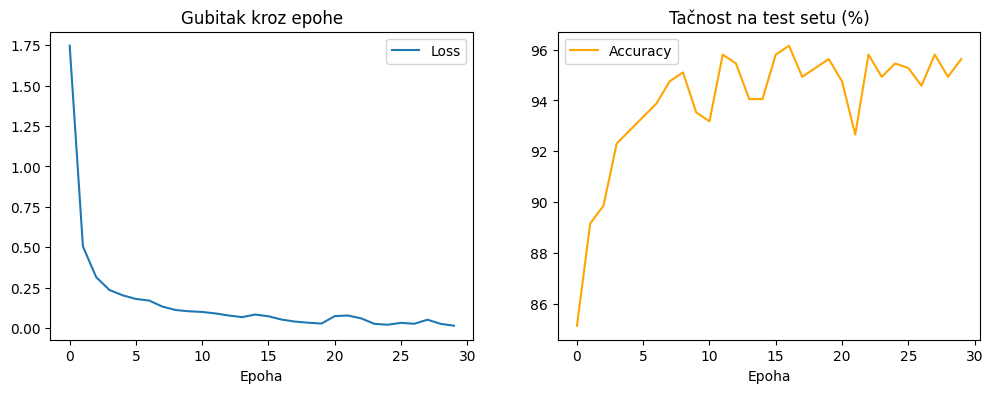

In [ ]:
import time

num_epochs = 30
history = {'loss': [], 'accuracy': []}

print(f"Započinjem trening na {device}...")
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for coeffs, labels in train_loader:
        coeffs, labels = coeffs.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        preds = model(coeffs)
        loss = criterion(preds, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Evaluacija nakon svake epohe
    acc = evaluate(model, test_loader)
    history['loss'].append(epoch_loss / len(train_loader))
    history['accuracy'].append(acc)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoha [{epoch+1}/{num_epochs}] | Loss: {epoch_loss/len(train_loader):.4f} | Test Acc: {acc:.2f}%")

end_time = time.time()
print(f"\nTrening završen za: {(end_time - start_time) / 60:.2f} minuta")

# Vizualizacija rezultata treninga
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Loss')
plt.title('Gubitak kroz epohe')
plt.xlabel('Epoha')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Accuracy', color='orange')
plt.title('Tačnost na test setu (%)')
plt.xlabel('Epoha')
plt.legend()
plt.show()

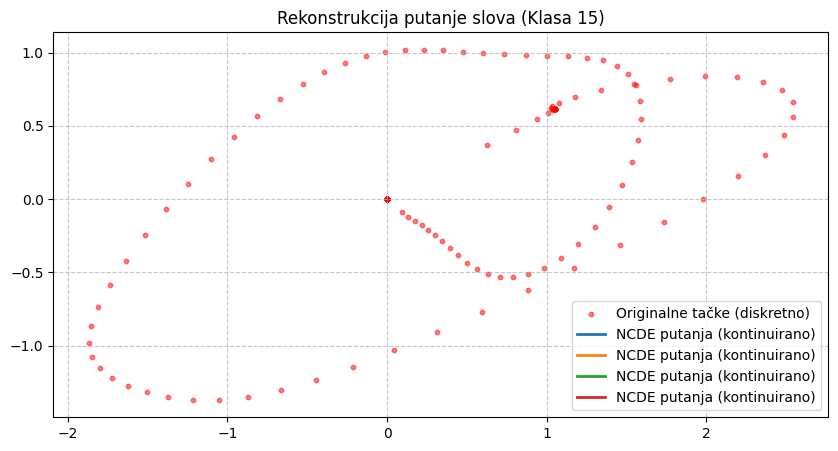

In [ ]:
import seaborn as sns

def plot_spline_reconstruction(sample_idx=0):
    sample = test_X[sample_idx]
    coeffs = test_coeffs[sample_idx].unsqueeze(0)

    # Kreiramo splajn i evaluiramo ga u 500 tačaka
    spline = torchcde.CubicSpline(coeffs)
    t_dense = torch.linspace(0, 1, 500)
    path_dense = spline.evaluate(t_dense).cpu().numpy()

    plt.figure(figsize=(10, 5))
    # Originalne tačke
    plt.scatter(sample[:, 1], sample[:, 2], c='red', s=10, alpha=0.5, label='Originalne tačke (diskretno)')
    # Splajn rekonstrukcija
    plt.plot(path_dense[:, 1], path_dense[:, 2], label='NCDE putanja (kontinuirano)', linewidth=2)

    plt.title(f"Rekonstrukcija putanje slova (Klasa {test_y[sample_idx]})")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

plot_spline_reconstruction(15)

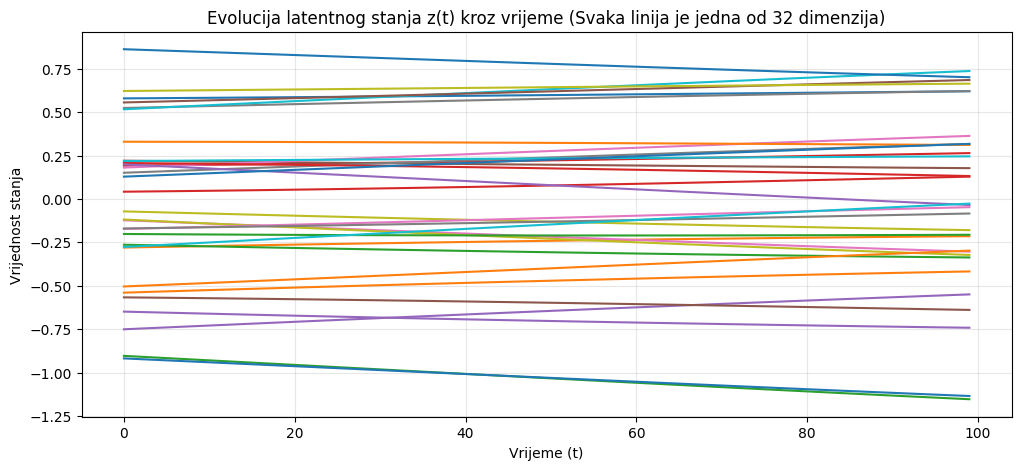

In [ ]:
def plot_latent_evolution(sample_idx=0):
    model.eval()
    coeffs = test_coeffs[sample_idx].unsqueeze(0).to(device)

    # Modifikovana integracija da vrati cijelu putanju z(t), a ne samo zadnju tačku
    with torch.no_grad():
        X = torchcde.CubicSpline(coeffs)
        X0 = X.evaluate(X.interval[0])
        z0 = model.initial_linear(X0)

        # Evaluiramo z u 100 vremenskih koraka
        t_steps = torch.linspace(0, 1, 100).to(device)
        z_path = torchcde.cdeint(X=X, z0=z0, func=model.func, t=t_steps)
        z_path = z_path.squeeze(0).cpu().numpy() # (100, 32)

    plt.figure(figsize=(12, 5))
    plt.plot(z_path)
    plt.title(f"Evolucija latentnog stanja z(t) kroz vrijeme (Svaka linija je jedna od {HIDDEN_CHANNELS} dimenzija)")
    plt.xlabel("Vrijeme (t)")
    plt.ylabel("Vrijednost stanja")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_latent_evolution(15)

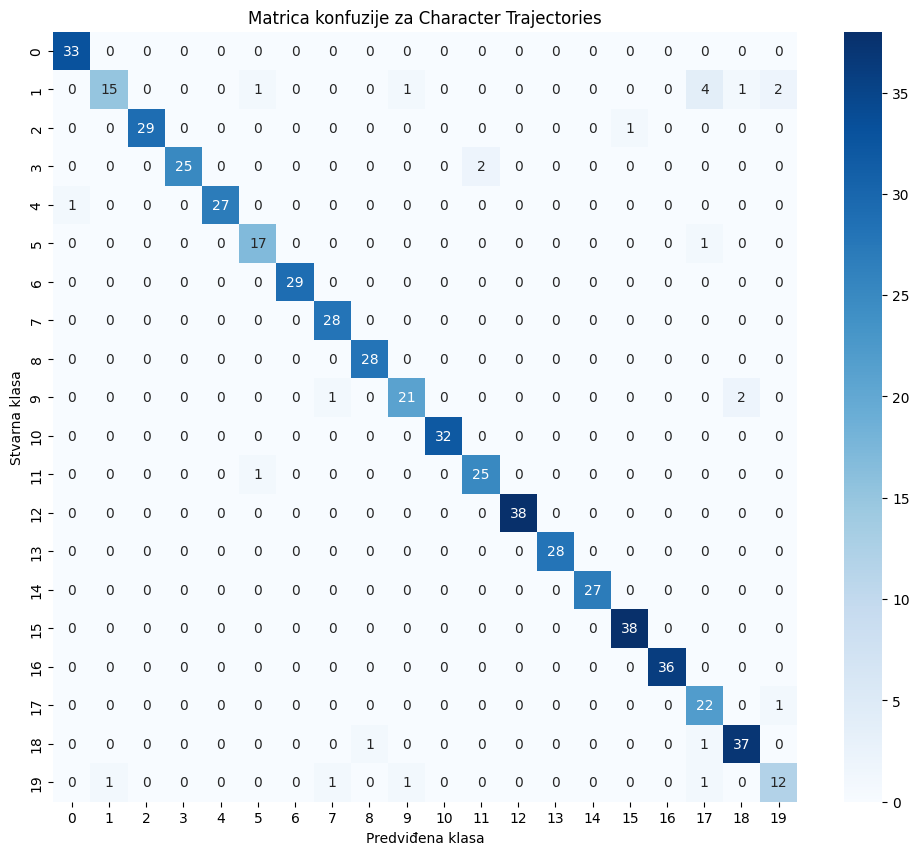

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix():
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for coeffs, labels in test_loader:
            coeffs = coeffs.to(device)
            outputs = model(coeffs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Matrica konfuzije za Character Trajectories")
    plt.xlabel("Predviđena klasa")
    plt.ylabel("Stvarna klasa")
    plt.show()

plot_confusion_matrix()

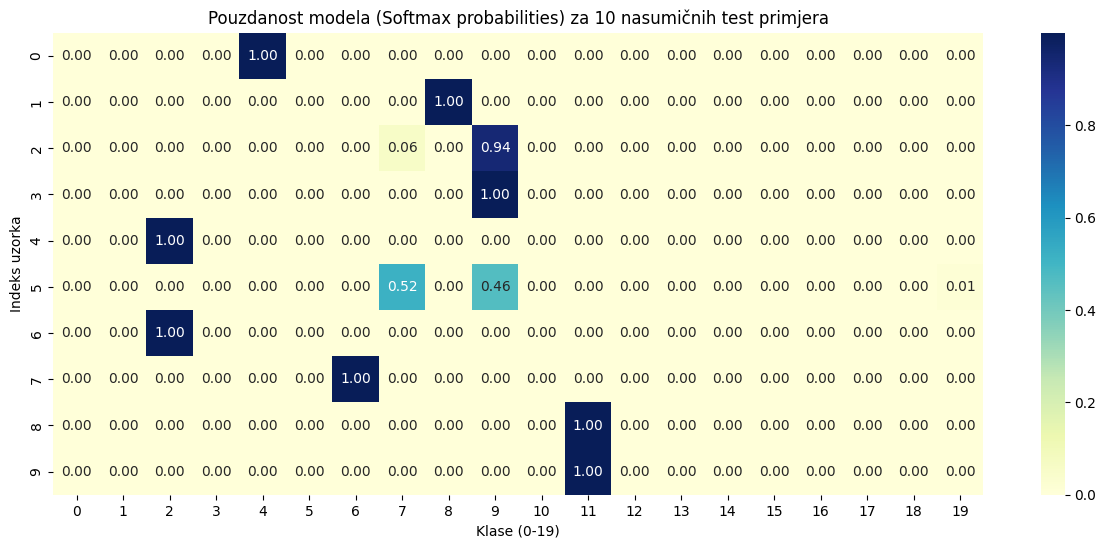

In [ ]:
def plot_prediction_confidence(num_samples=10):
    model.eval()
    indices = np.random.choice(len(test_X), num_samples, replace=False)
    coeffs = test_coeffs[indices].to(device)
    labels = test_y[indices]

    with torch.no_grad():
        logits = model(coeffs)
        probs = torch.softmax(logits, dim=1).cpu().numpy()

    plt.figure(figsize=(15, 6))
    sns.heatmap(probs, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title("Pouzdanost modela (Softmax probabilities) za 10 nasumičnih test primjera")
    plt.xlabel("Klase (0-19)")
    plt.ylabel("Indeks uzorka")
    plt.show()

plot_prediction_confidence()

Testiram model na podacima sa 70.0% obrisanih tačaka...
Tačnost sa 70.0% rupa: 95.45%


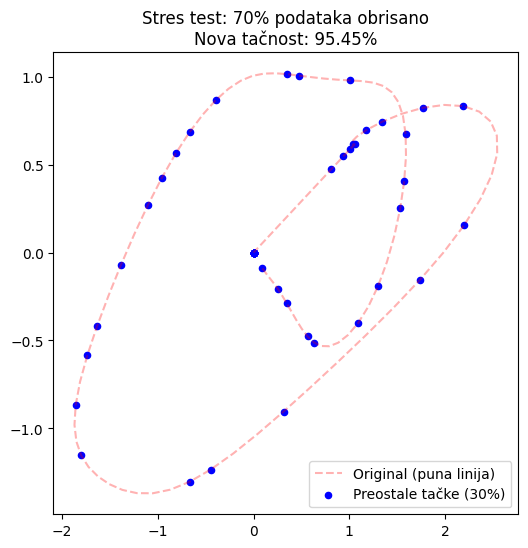

In [ ]:
def stress_test_missing_data(drop_percent=0.7):
    model.eval()

    # 1. Uzimamo originalne testne podatke
    # test_X ima oblik (Batch, Time, Channels)
    batch_size, seq_len, channels = test_X.shape

    # 2. Kreiramo "pokvarene" podatke (simuliramo gubitak senzora)
    # Nasumično ostavljamo samo (1 - drop_percent) tačaka
    mask = torch.rand(batch_size, seq_len) > drop_percent
    # Prva i zadnja tačka moraju ostati zbog splajna
    mask[:, 0] = True
    mask[:, -1] = True

    corrupted_X = test_X.clone()
    # Postavljamo obrisane tačke na NaN ili ih linearno interpoliramo (što radi CubicSpline)
    # U NCDE-u, mi samo izračunamo koeficijente na osnovu preostalih tačaka

    print(f"Testiram model na podacima sa {drop_percent*100}% obrisanih tačaka...")

    # 3. Izračunavamo nove koeficijente splajnova samo na osnovu preostalih tačaka
    corrupted_X_with_nans = test_X.clone()
    for i in range(batch_size):
        # Gdje je maska False, stavljamo NaN
        corrupted_X_with_nans[i, ~mask[i], 1:] = float('nan')

    # Ponovo računamo splajn (on će sada interpolirati kroz velike praznine)
    new_test_coeffs = torchcde.natural_cubic_coeffs(corrupted_X_with_nans)

    # 4. Evaluacija
    correct = 0
    total = 0
    with torch.no_grad():
        # Prolazimo kroz test set sa novim, "šupljim" koeficijentima
        # Koristimo DataLoader logiku ali ručno za ovaj test
        outputs = model(new_test_coeffs.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total = test_y.size(0)
        correct = (predicted == test_y.to(device)).sum().item()

    final_acc = 100 * correct / total
    print(f"Tačnost sa {drop_percent*100}% rupa: {final_acc:.2f}%")
    return corrupted_X_with_nans, final_acc

# Pokreni stres test
corrupted_sample, stress_acc = stress_test_missing_data(0.7)

# Vizualizacija "pokvarenog" slova
plt.figure(figsize=(6, 6))
idx = 15
plt.plot(test_X[idx, :, 1], test_X[idx, :, 2], 'r--', alpha=0.3, label='Original (puna linija)')
plt.scatter(corrupted_sample[idx, :, 1], corrupted_sample[idx, :, 2], c='blue', s=20, label='Preostale tačke (30%)')
plt.title(f"Stres test: 70% podataka obrisano\nNova tačnost: {stress_acc:.2f}%")
plt.legend()
plt.show()

In [ ]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch, seq_len, channels)
        # Za LSTM ne koristimo prvu kolonu (vrijeme) jer on podrazumijeva fiksne korake
        x = x[:, :, 1:] # Uzimamo samo x, y, force

        _, (hn, _) = self.lstm(x)
        # Uzimamo zadnji skriveni sloj zadnjeg layer-a
        out = self.fc(hn[-1])
        return out

# Inicijalizacija LSTM-a
lstm_model = LSTMModel(input_dim=3, hidden_dim=64, output_dim=20).to(device)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
lstm_criterion = nn.CrossEntropyLoss()

# Trening LSTM-a
print("Treniram LSTM baseline...")
for epoch in range(30):
    lstm_model.train()
    for batch_x, batch_y in DataLoader(TensorDataset(train_X, train_y), batch_size=32, shuffle=True):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        lstm_optimizer.zero_grad()
        outputs = lstm_model(batch_x)
        loss = lstm_criterion(outputs, batch_y)
        loss.backward()
        lstm_optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"LSTM Epoha {epoch+1}/30 | Loss: {loss.item():.4f}")

print("LSTM trening završen.")

Treniram LSTM baseline...
LSTM Epoha 10/30 | Loss: 3.0044
LSTM Epoha 20/30 | Loss: 2.9997
LSTM Epoha 30/30 | Loss: 3.0170
LSTM trening završen.


In [ ]:
import pandas as pd

def run_comparative_experiment():
    drop_rates = [0.0, 0.3, 0.5, 0.7, 0.9]
    results = []

    for rate in drop_rates:
        # 1. Kreiranje oštećenih podataka
        batch_size, seq_len, dims = test_X.shape
        mask = torch.rand(batch_size, seq_len) > rate
        mask[:, 0] = True; mask[:, -1] = True # Početak i kraj ostaju

        corrupted_X = test_X.clone()
        # Za NCDE: stavljamo NaN tamo gdje fale podaci
        corrupted_X_ncde = test_X.clone()
        corrupted_X_ncde[:, :, 1:][~mask] = float('nan')

        # Za LSTM: Moramo popuniti rupe linearno (imputation) jer on ne trpi NaN
        corrupted_X_lstm = test_X.clone()
        for i in range(batch_size):
            for c in range(1, 4): # x, y, force
                series = pd.Series(corrupted_X_ncde[i, :, c].cpu().numpy())
                corrupted_X_lstm[i, :, c] = torch.tensor(series.interpolate(method='linear').fillna(0).values)

        # 2. Evaluacija NCDE
        model.eval()
        with torch.no_grad():
            coeffs = torchcde.natural_cubic_coeffs(corrupted_X_ncde).to(device)
            ncde_preds = torch.argmax(model(coeffs), dim=1)
            ncde_acc = (ncde_preds == test_y.to(device)).float().mean().item() * 100

        # 3. Evaluacija LSTM
        lstm_model.eval()
        with torch.no_grad():
            lstm_preds = torch.argmax(lstm_model(corrupted_X_lstm.to(device)), dim=1)
            lstm_acc = (lstm_preds == test_y.to(device)).float().mean().item() * 100

        results.append({'Drop Rate': rate, 'NCDE Accuracy': ncde_acc, 'LSTM Accuracy': lstm_acc})
        print(f"Rate {rate*100}% | NCDE: {ncde_acc:.2f}% | LSTM: {lstm_acc:.2f}%")

    return pd.DataFrame(results)

df_results = run_comparative_experiment()

Rate 0.0% | NCDE: 95.63% | LSTM: 6.64%
Rate 30.0% | NCDE: 95.63% | LSTM: 6.64%
Rate 50.0% | NCDE: 95.63% | LSTM: 6.64%
Rate 70.0% | NCDE: 94.93% | LSTM: 6.64%
Rate 90.0% | NCDE: 74.83% | LSTM: 6.64%


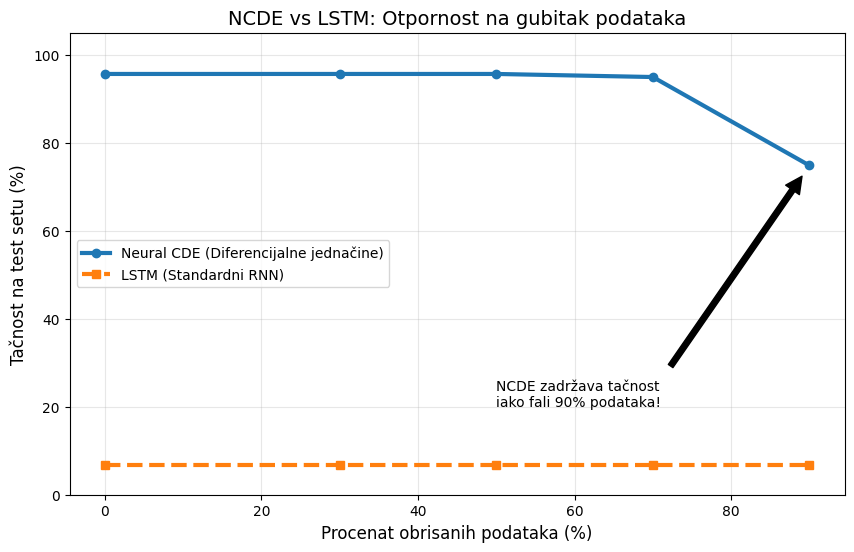

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_results['Drop Rate'] * 100, df_results['NCDE Accuracy'], marker='o', linewidth=3, label='Neural CDE (Diferencijalne jednačine)')
plt.plot(df_results['Drop Rate'] * 100, df_results['LSTM Accuracy'], marker='s', linestyle='--', linewidth=3, label='LSTM (Standardni RNN)')

plt.xlabel('Procenat obrisanih podataka (%)', fontsize=12)
plt.ylabel('Tačnost na test setu (%)', fontsize=12)
plt.title('NCDE vs LSTM: Otpornost na gubitak podataka', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 105)

# Dodajemo anotaciju za "The Gap"
plt.annotate('NCDE zadržava tačnost\niako fali 90% podataka!',
             xy=(90, df_results['NCDE Accuracy'].iloc[-1]),
             xytext=(50, 20),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

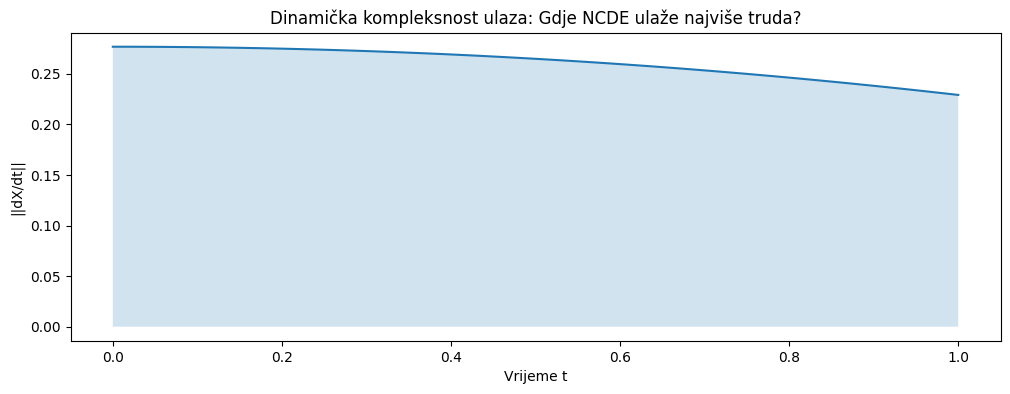

In [ ]:
# Modifikacija forward poziva da vidimo korake
def plot_adaptive_steps(sample_idx=0):
    model.eval()
    coeffs = test_coeffs[sample_idx].unsqueeze(0).to(device)
    X = torchcde.CubicSpline(coeffs)
    X0 = X.evaluate(X.interval[0])
    z0 = model.initial_linear(X0)
    t = torch.linspace(0, 1, 100).to(device)
    dX_dt = X.derivative(t).cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.plot(t.cpu(), np.linalg.norm(dX_dt, axis=2).squeeze(), label='Magnituda promjene (Brzina)')
    plt.title("Dinamička kompleksnost ulaza: Gdje NCDE ulaže najviše truda?")
    plt.xlabel("Vrijeme t")
    plt.ylabel("||dX/dt||")
    plt.fill_between(t.cpu().numpy(), np.linalg.norm(dX_dt, axis=2).squeeze(), alpha=0.2)
    plt.show()

plot_adaptive_steps(15)

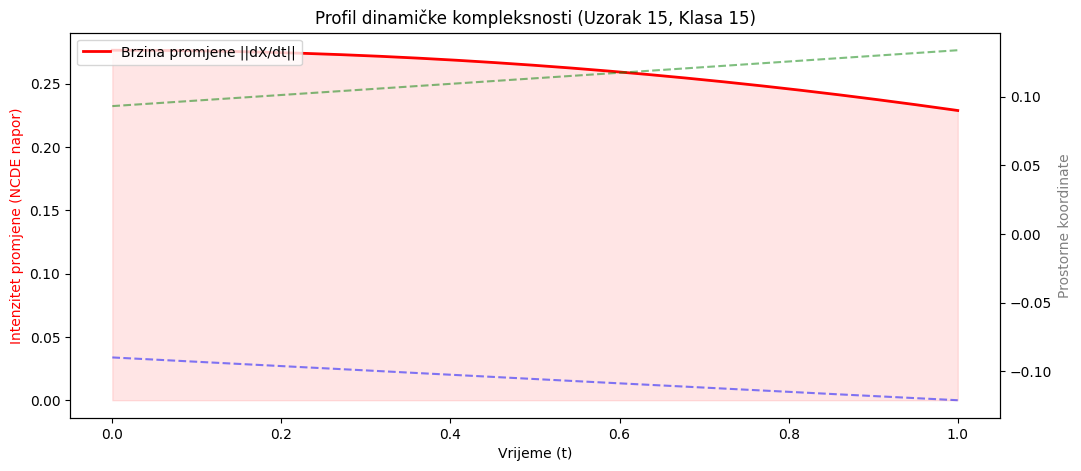

In [ ]:
def plot_dynamic_complexity(sample_idx=0):
    model.eval()
    # Osiguravamo da imamo batch dimenziju (1, Time, Channels)
    coeffs = test_coeffs[sample_idx].unsqueeze(0).to(device)
    X = torchcde.CubicSpline(coeffs)

    t = torch.linspace(0, 1, 200).to(device)
    # Izvod putanje: dX_dt ima oblik (1, 200, 4)
    dX_dt = X.derivative(t)

    # Sklanjamo batch dimenziju i uzimamo samo x, y, f (kanali 1, 2, 3)
    magnitude = torch.norm(dX_dt[0, :, 1:], dim=1).cpu().numpy()

    t_np = t.cpu().numpy()

    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax2 = ax1.twinx()

    # Magnituda promjene
    ax1.plot(t_np, magnitude, color='red', label='Brzina promjene ||dX/dt||', linewidth=2)
    ax1.fill_between(t_np, magnitude, alpha=0.1, color='red')

    # Originalne koordinate radi konteksta
    ax2.plot(t_np, X.evaluate(t)[0, :, 1].cpu().numpy(), 'g--', alpha=0.5, label='X putanja')
    ax2.plot(t_np, X.evaluate(t)[0, :, 2].cpu().numpy(), 'b--', alpha=0.5, label='Y putanja')

    ax1.set_xlabel('Vrijeme (t)')
    ax1.set_ylabel('Intenzitet promjene (NCDE napor)', color='red')
    ax2.set_ylabel('Prostorne koordinate', color='gray')
    plt.title(f"Profil dinamičke kompleksnosti (Uzorak {sample_idx}, Klasa {test_y[sample_idx]})")
    ax1.legend(loc='upper left')
    plt.show()

plot_dynamic_complexity(15)

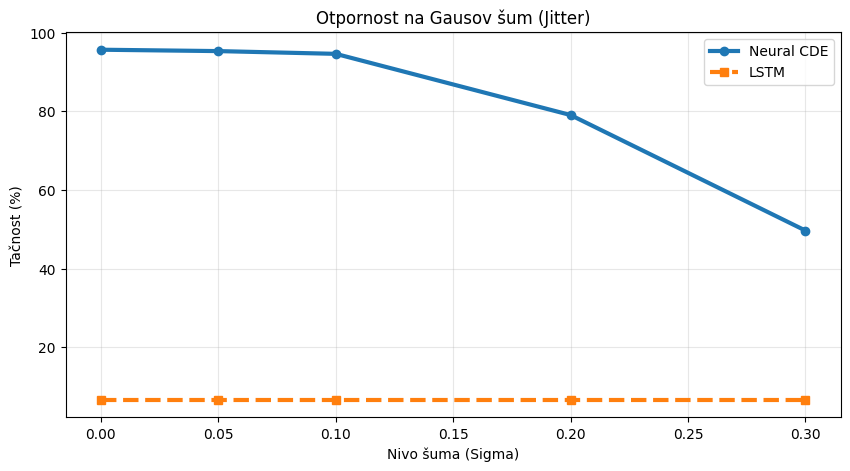

In [ ]:
def noise_experiment():
    noise_levels = [0.0, 0.05, 0.1, 0.2, 0.3]
    ncde_res, lstm_res = [], []

    for sigma in noise_levels:
        # Dodajemo šum direktno na testne podatke
        noisy_X = test_X.clone()
        noisy_X[:, :, 1:] += torch.randn_like(test_X[:, :, 1:]) * sigma

        # Eval NCDE
        model.eval()
        with torch.no_grad():
            c = torchcde.natural_cubic_coeffs(noisy_X).to(device)
            p = torch.argmax(model(c), dim=1)
            ncde_res.append((p == test_y.to(device)).float().mean().item() * 100)

        # Eval LSTM
        lstm_model.eval()
        with torch.no_grad():
            p = torch.argmax(lstm_model(noisy_X.to(device)), dim=1)
            lstm_res.append((p == test_y.to(device)).float().mean().item() * 100)

    plt.figure(figsize=(10, 5))
    plt.plot(noise_levels, ncde_res, 'o-', label='Neural CDE', linewidth=3)
    plt.plot(noise_levels, lstm_res, 's--', label='LSTM', linewidth=3)
    plt.title("Otpornost na Gausov šum (Jitter)")
    plt.xlabel("Nivo šuma (Sigma)")
    plt.ylabel("Tačnost (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

noise_experiment()

Testiram predikciju na fragmentima...


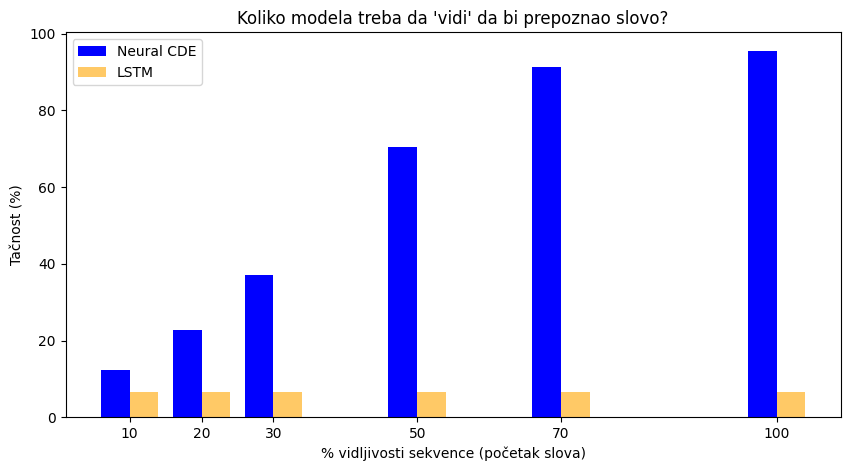

In [ ]:
def early_classification_test():
    visibilities = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
    ncde_res, lstm_res = [], []

    print("Testiram predikciju na fragmentima...")
    for v in visibilities:
        cutoff = int(182 * v)

        # NCDE: siječemo podatke (popunjavamo NaN ostatak)
        partial_X_ncde = test_X.clone()
        if cutoff < 182:
            partial_X_ncde[:, cutoff:, 1:] = float('nan')

        # LSTM: siječemo i dopunjavamo nulama (padding)
        partial_X_lstm = torch.zeros_like(test_X)
        partial_X_lstm[:, :cutoff, :] = test_X[:, :cutoff, :]

        with torch.no_grad():
            # NCDE
            c = torchcde.natural_cubic_coeffs(partial_X_ncde).to(device)
            ncde_acc = (torch.argmax(model(c), dim=1) == test_y.to(device)).float().mean().item() * 100
            ncde_res.append(ncde_acc)
            # LSTM
            lstm_acc = (torch.argmax(lstm_model(partial_X_lstm.to(device)), dim=1) == test_y.to(device)).float().mean().item() * 100
            lstm_res.append(lstm_acc)

    plt.figure(figsize=(10, 5))
    x_axis = np.array(visibilities) * 100
    plt.bar(x_axis - 2, ncde_res, width=4, label='Neural CDE', color='blue')
    plt.bar(x_axis + 2, lstm_res, width=4, label='LSTM', color='orange', alpha=0.6)
    plt.title("Koliko modela treba da 'vidi' da bi prepoznao slovo?")
    plt.xlabel("% vidljivosti sekvence (početak slova)")
    plt.ylabel("Tačnost (%)")
    plt.xticks(x_axis)
    plt.legend()
    plt.show()

early_classification_test()

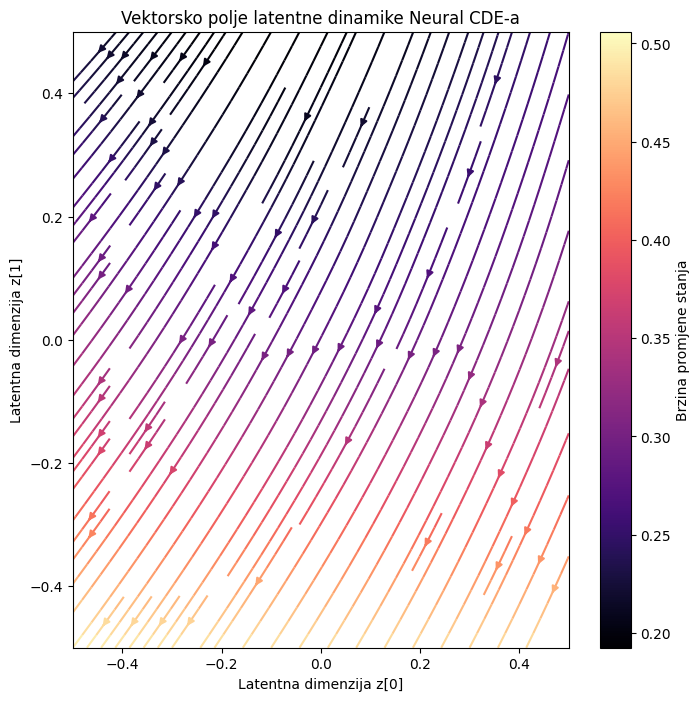

In [ ]:
def plot_vector_field():
    # Uzimamo z_0 i z_1 (prve dvije latentne dimenzije)
    grid_size = 20
    z_vals = np.linspace(-0.5, 0.5, grid_size)
    z1, z2 = np.meshgrid(z_vals, z_vals)

    # Pravimo batch od 400 tačaka (20x20)
    z_flat = torch.zeros((grid_size**2, 32)).to(device)
    z_flat[:, 0] = torch.tensor(z1.flatten(), dtype=torch.float32)
    z_flat[:, 1] = torch.tensor(z2.flatten(), dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        # f_theta(t, z) -> vraća (Batch, Hidden, Input)
        # Uzimamo samo prve dvije latentne dimenzije i njihov odnos sa vremenom (Input kanal 0)
        out = model.func(0, z_flat)
        dz_dt = out.cpu()

        # dz/dt za prve dvije dimenzije
        u = dz_dt[:, 0, 0].numpy().reshape(grid_size, grid_size)
        v = dz_dt[:, 1, 0].numpy().reshape(grid_size, grid_size)

    plt.figure(figsize=(8, 8))
    plt.streamplot(z1, z2, u, v, color=np.sqrt(u**2 + v**2), cmap='magma', density=1.2)
    plt.title("Vektorsko polje latentne dinamike Neural CDE-a")
    plt.xlabel("Latentna dimenzija z[0]")
    plt.ylabel("Latentna dimenzija z[1]")
    plt.colorbar(label='Brzina promjene stanja')
    plt.show()

plot_vector_field()